## Este codigo es para el diseno de ataques

### Librerías necesarias

In [1]:
from os.path import join
from os import getenv
from matplotlib.image import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow as tf
from dotenv import load_dotenv

load_dotenv(override=True)

True

# Definición de rutas

In [2]:
data_path = getenv('DATA_PATH')
models_path = getenv('MODELS_PATH')
train_data_path = join(data_path, 'Train')
labels_path = join(data_path, 'Test.csv')

### Cargar imágenes de testeo

In [3]:
data = []
labels = []
Table = pd.read_csv(labels_path)
Table['Path']
for j in range(0,Table['Path'].shape[0]):
    ima_path =join(data_path, Table['Path'][j])
    imagen = imread(ima_path,-1)
    imagen = resize(imagen,(32,32))
    data.append(imagen)
    labels.append(Table['ClassId'][j])

In [4]:
data2 = np.array(data)
labels2 = np.array(labels)
print(data2.shape,labels2.shape)

(12630, 32, 32, 3) (12630,)


In [5]:
X_test = data2
y_test = labels2

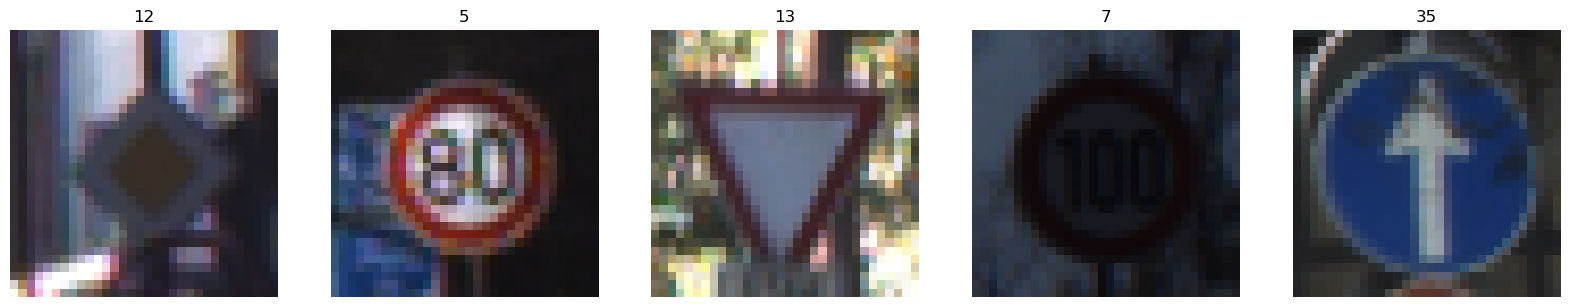

In [6]:
test_images = [X_test[10], X_test[30], X_test[26], X_test[40],  X_test[9]]
test_labels = [y_test[10], y_test[30], y_test[26], y_test[40], y_test[9]]
plt.figure(figsize=(20, 10))
for i in range(5):
      ax = plt.subplot(1, 5, i + 1)
      plt.imshow(test_images[i])
      plt.title(test_labels[i])
      plt.axis("off")

In [7]:
class AttackModel():
    def __init__(self, model, images, epsilons):
        self.model = model
        self.images = images
        self.epsilons = epsilons
        
    def predict(self, image):
        ref = np.argmax(self.model(image))
        return tf.constant(to_categorical(ref, 43).reshape(1, 43))
    
    def get_adversarial_image(self, image, epsilon, target=None, pixel_number = None):
        image = tf.cast(image.reshape(1, 32, 32, 3), tf.float32)
        if target is None:
            label = self.predict(image)
        else:
            label = tf.constant(to_categorical(target, 43).reshape(1, 43))
        with tf.GradientTape() as tape:
            tape.watch(image)
            prediction = self.model(image)
            loss = CategoricalCrossentropy()(label, prediction)
        gradient = tape.gradient(loss, image)
        signed_grad = tf.sign(gradient)
        disturbance = signed_grad[0] * 0.5 + 0.5 

        if pixel_number is not None:
            pixels_to_perturb = np.random.choice(range(32*32), size=pixel_number, replace=False)
            signed_grad_pixels = np.zeros((32, 32, 3))
            for p in pixels_to_perturb:
                x, y = p % 32, p // 32
                signed_grad_pixels[x, y, :] = signed_grad[0, x, y, :]
            adversarial_image = (image + epsilon * signed_grad_pixels) if target is None else (image - epsilon * signed_grad_pixels )
            y_disturbance = np.argmax(self.model(adversarial_image))
            disturbance_pixels = signed_grad_pixels * 0.5 + 0.5
            return adversarial_image, y_disturbance, disturbance_pixels

        adversarial_image = (image + epsilon * signed_grad) if target is None else (image - epsilon * signed_grad)
        y_disturbance = np.argmax(self.model(adversarial_image))
        return adversarial_image, y_disturbance, disturbance
    
    def get_adversarial_images(self, targets=None, pixel_number = None):
        adv_images = []
        adv_labels = []
        adv_disturbances = []
        for i in range(len(self.images)):
            adv_image, adv_label, adv_disturbance = self.get_adversarial_image(
                self.images[i], self.epsilons[i], targets[i] if targets else None, pixel_number)
            adv_image = adv_image.numpy().reshape(32, 32, 3)
            adv_images.append(adv_image)
            adv_labels.append(adv_label)
            adv_disturbances.append(adv_disturbance)
        return np.array(adv_images), np.array(adv_labels), np.array(adv_disturbances)


Definición de listas para almacenar las imágenes

In [8]:
# NDArray for append images
adversarial_images = np.empty((60,32,32,3))
adversarial_labels = np.empty(60)

# 1. Untargeted attack

### Modelo Andres-Ernesto

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[30  3 15  8 39]


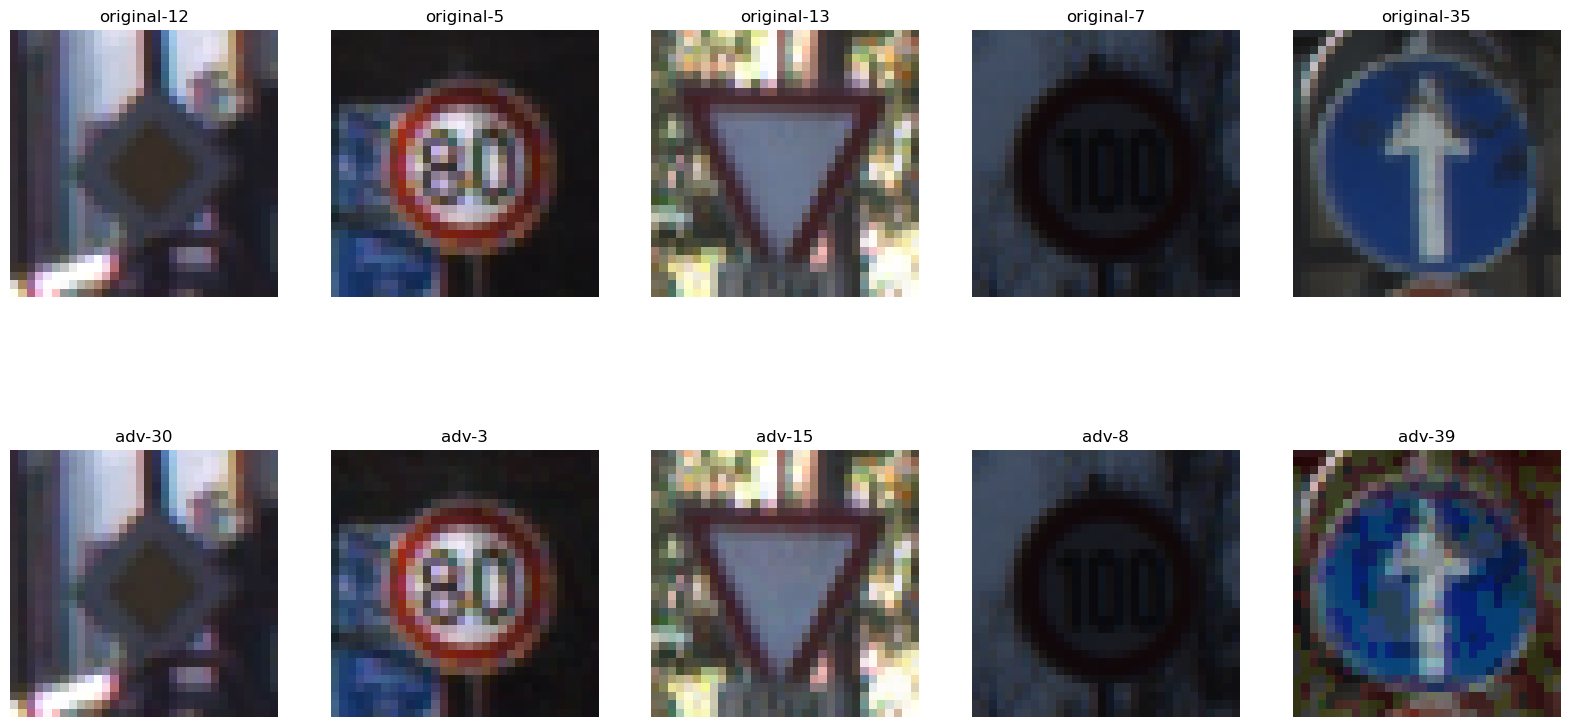

In [9]:
epsilons = [0.0058, 0.008, 0.013, 0.0009, 0.06]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()
adversarial_images[0:5] = adv_images
adversarial_labels[0:5] = adv_labels

print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

### Modelo Donovan-Jorge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[30  3 35  4 13]


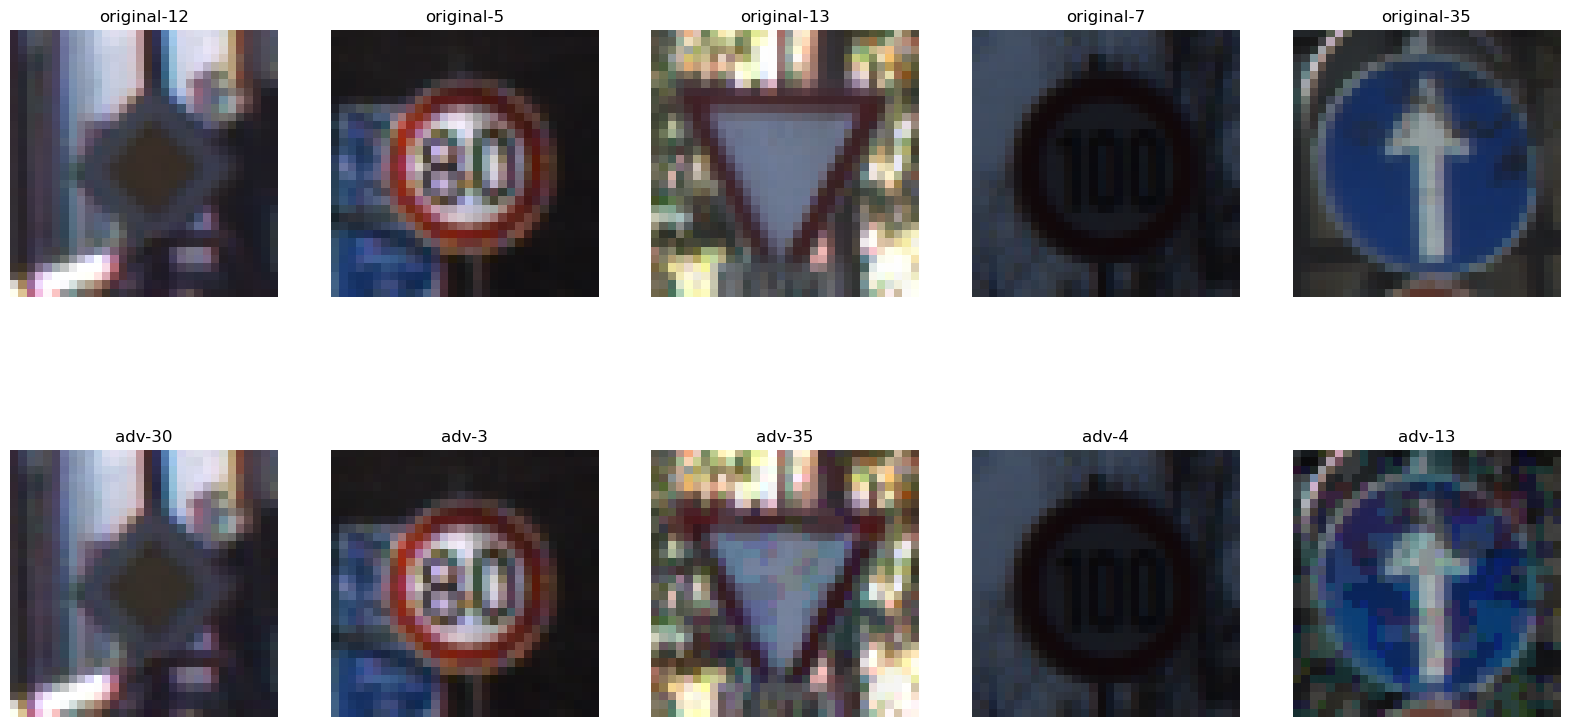

In [10]:
epsilons = [0.0077, 0.0038, 0.039, 0.0018, 0.047]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()
adversarial_images[5:10] = adv_images
adversarial_labels[5:10] = adv_labels

print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

### Modelo profesor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[38  6 33  4  9]


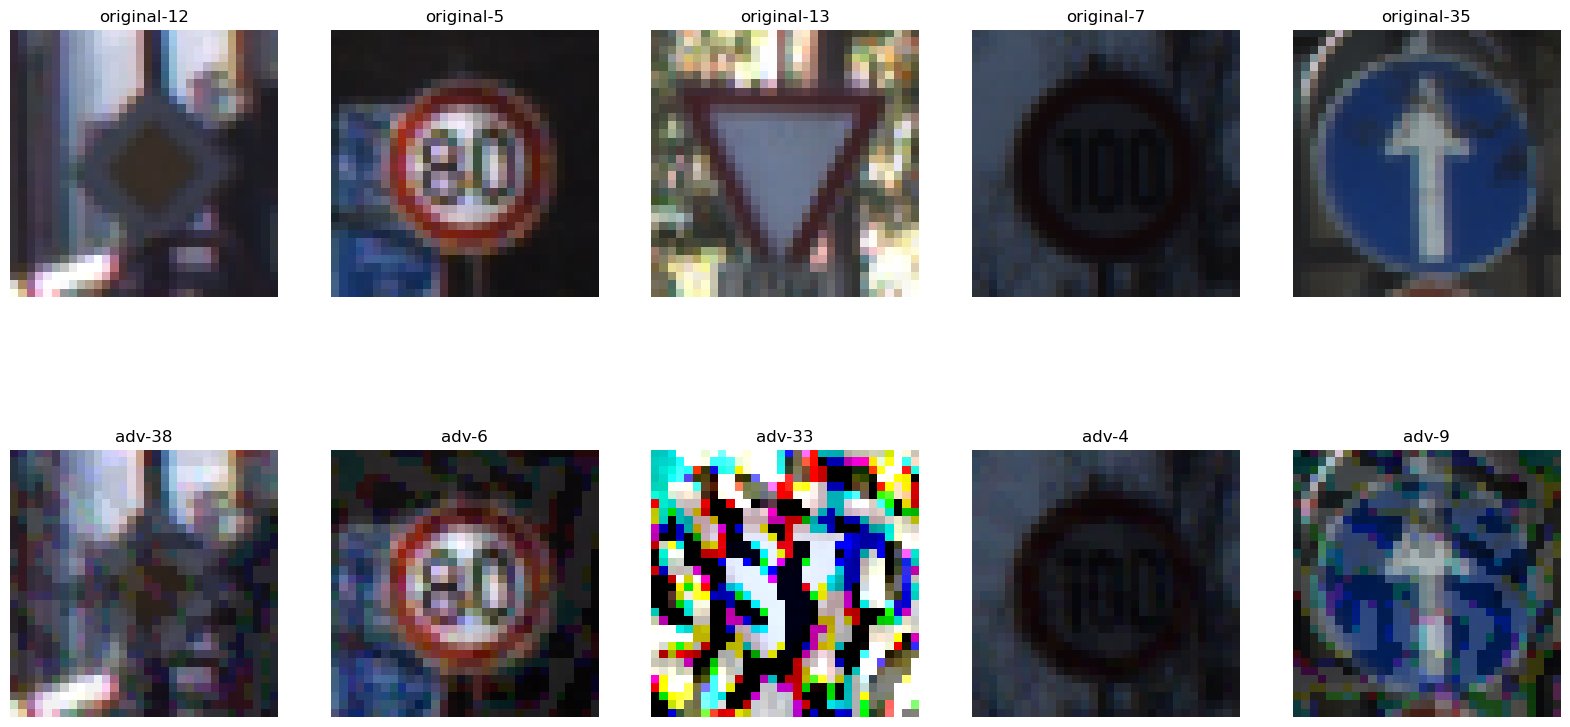

In [11]:
epsilons = [0.047, 0.047, 0.49, 0.013, 0.087]
attack_model = AttackModel(load_model(join(models_path, 'teacher.h5')), test_images, epsilons)
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images()
adversarial_images[10:15] = adv_images
adversarial_labels[10:15] = adv_labels
print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

# 2. Target attack

### Modelo Andres-Ernesto

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[11  4 12  6 34]


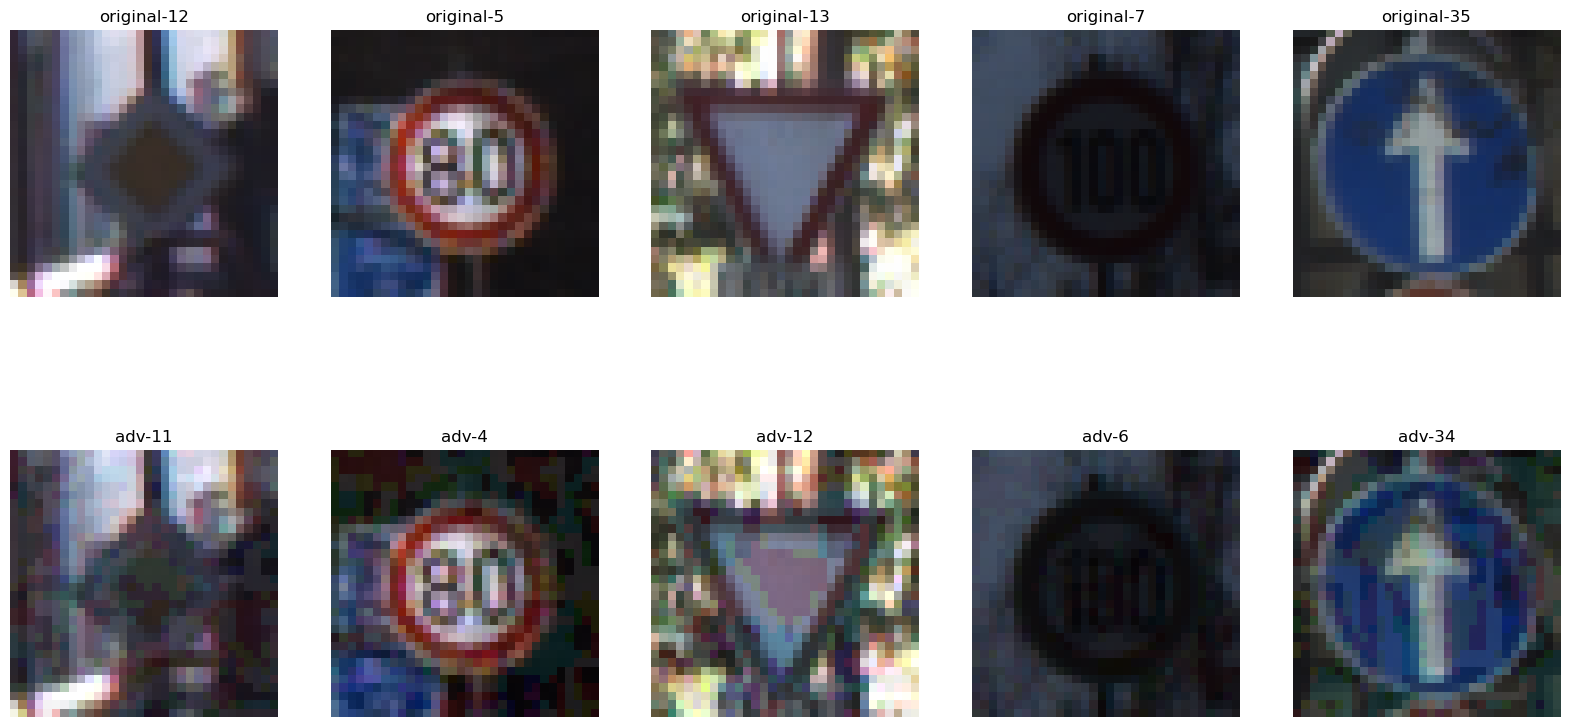

In [12]:
epsilons = [0.037, 0.044, 0.064, 0.015, 0.045]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)
adversarial_images[15:20] = adv_images
adversarial_labels[15:20] = adv_labels
print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

### Modelo Donovan-Jorge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[11  4 12  6 34]


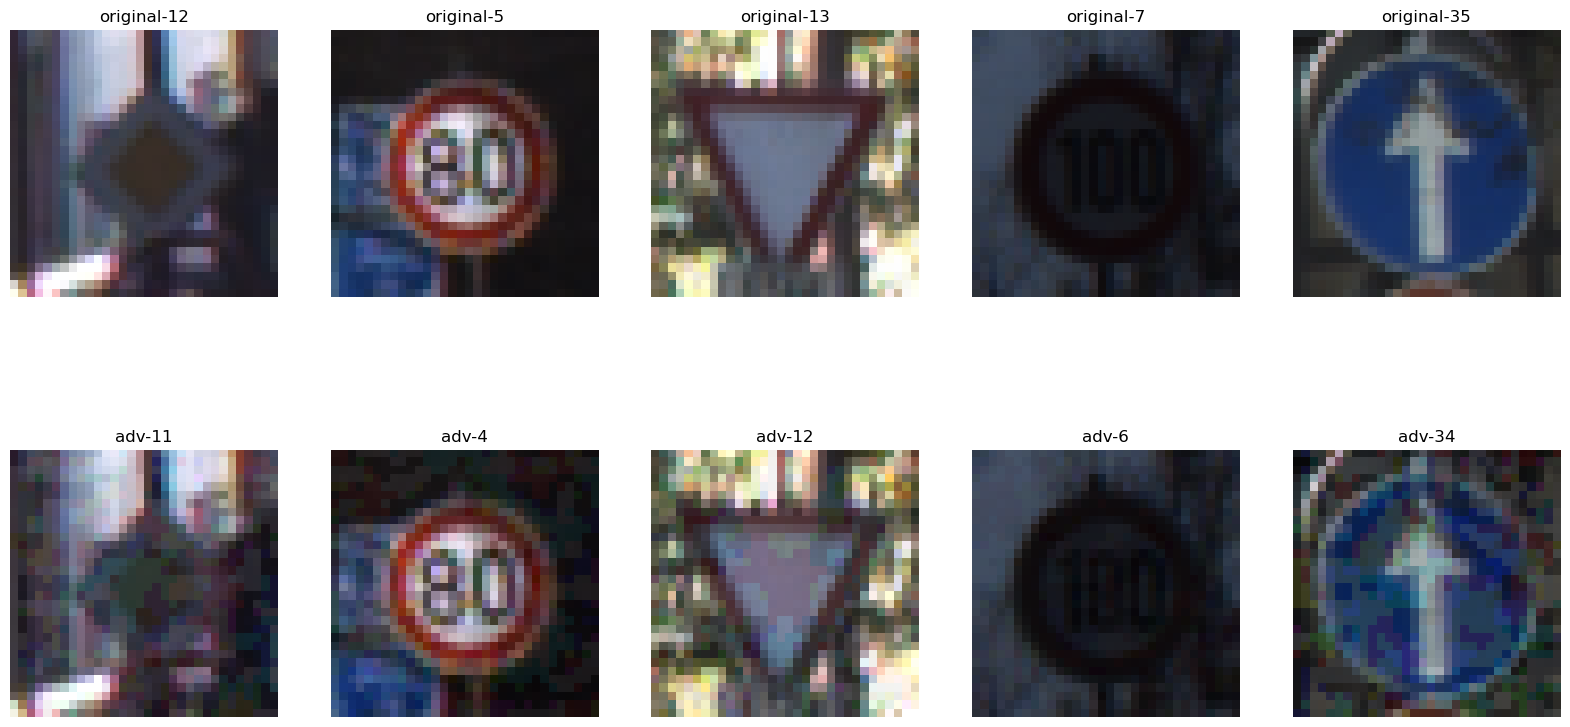

In [13]:
epsilons = [0.041, 0.03, 0.046, 0.011, 0.055]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)
adversarial_images[20:25] = adv_images
adversarial_labels[20:25] = adv_labels
print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

### Modelo profesor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[11  4 42  6 34]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


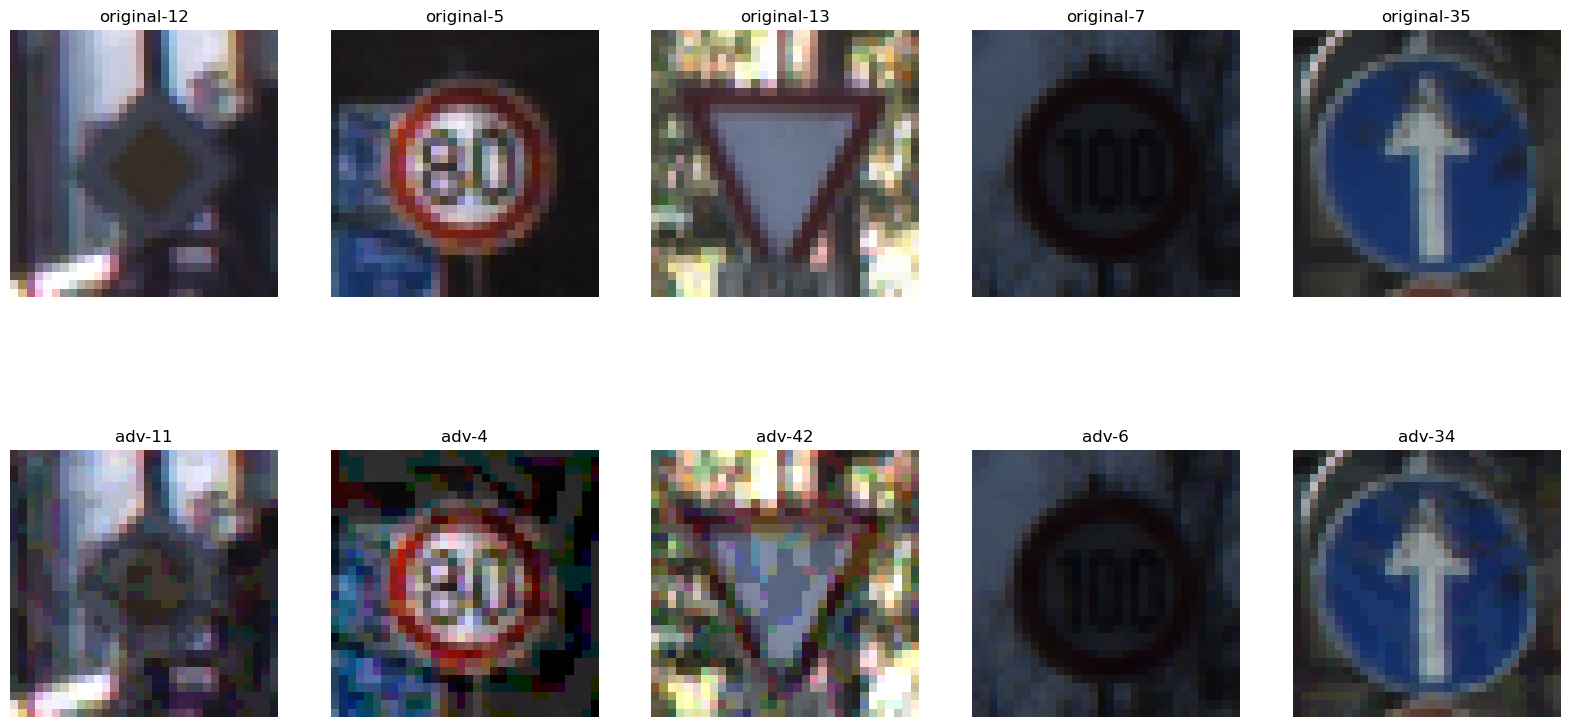

In [14]:
epsilons = [0.041, 0.074, 0.077, 0.0064, 0.019]
attack_model = AttackModel(load_model(join(models_path, 'teacher.h5')), test_images, epsilons)
targets = [test_labels[i]-1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets)
adversarial_images[25:30] = adv_images
adversarial_labels[25:30] = adv_labels
print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

## 3. Modificar 10 pixeles

### Modelo Andres-Ernesto

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[13  3 10 11 35]


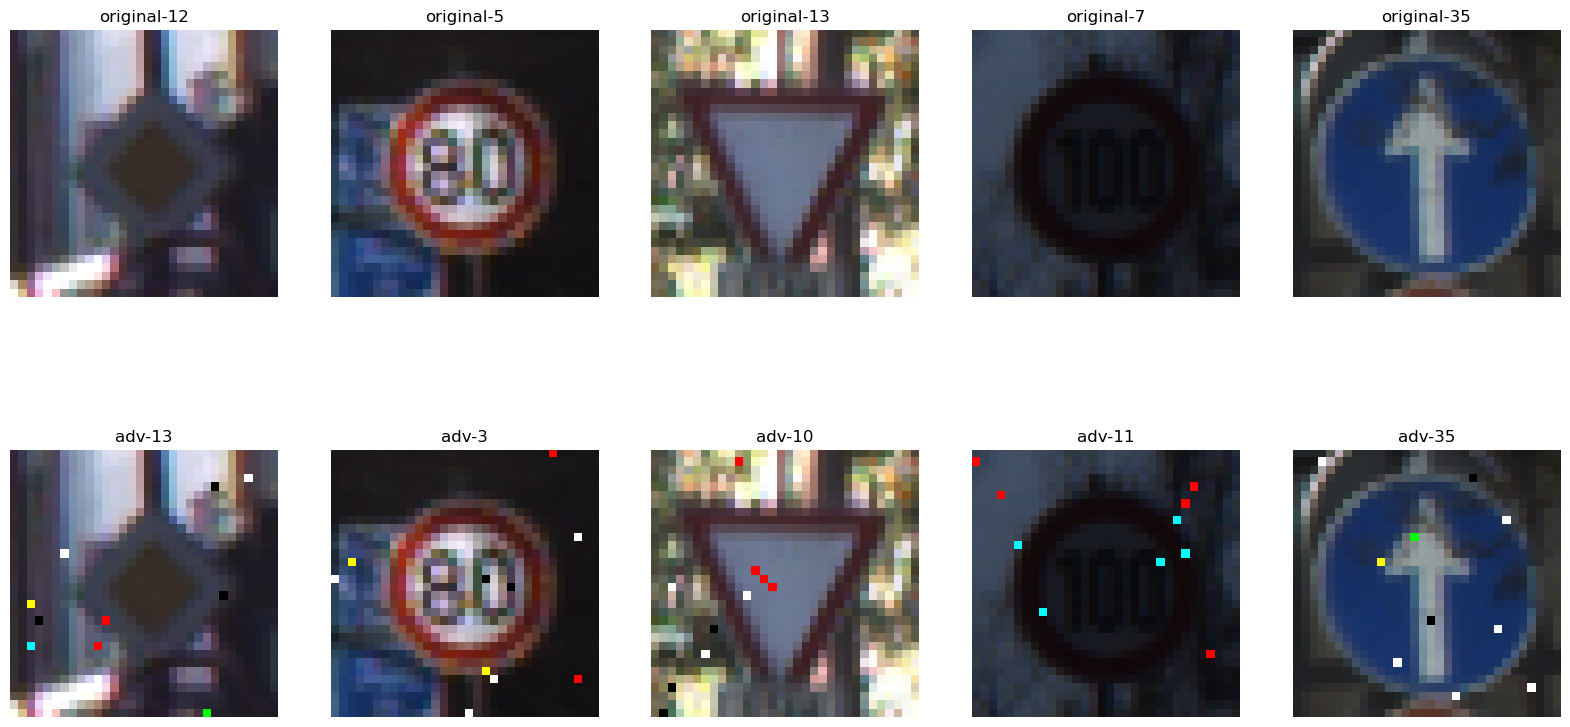

In [15]:
epsilons = [2.5, 4, 5.5, 2.5, 5.5]
attack_model = AttackModel(load_model(join(models_path, 'florez_solarte.h5')), test_images, epsilons)
targets = [test_labels[i] - 1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets, pixel_number=10)
adversarial_images[30:35] = adv_images
adversarial_labels[30:35] = adv_labels
print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

### Modelo Donovan-Jorge

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[ 1  4 12  2 13]


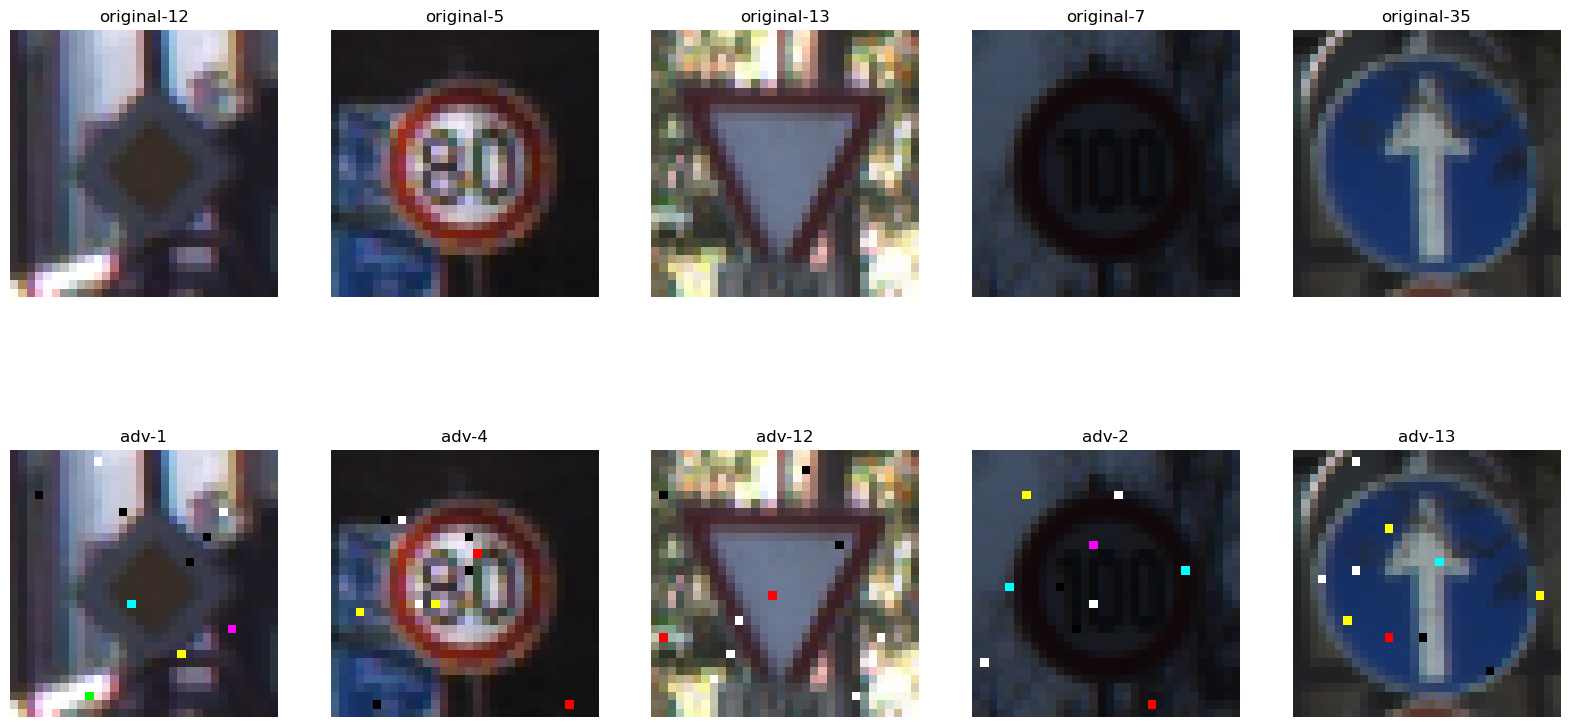

In [16]:
epsilons = [3.5, 4, 4.5, 2.5, 5.5]
attack_model = AttackModel(load_model(join(models_path, 'burbano_chamorro.h5')), test_images, epsilons)
targets = [test_labels[i] - 1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets, pixel_number=10)
adversarial_images[35:40] = adv_images
adversarial_labels[35:40] = adv_labels
print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

### Modelo profesor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[12, 5, 13, 7, 35]
[ 6  1 13 12 40]


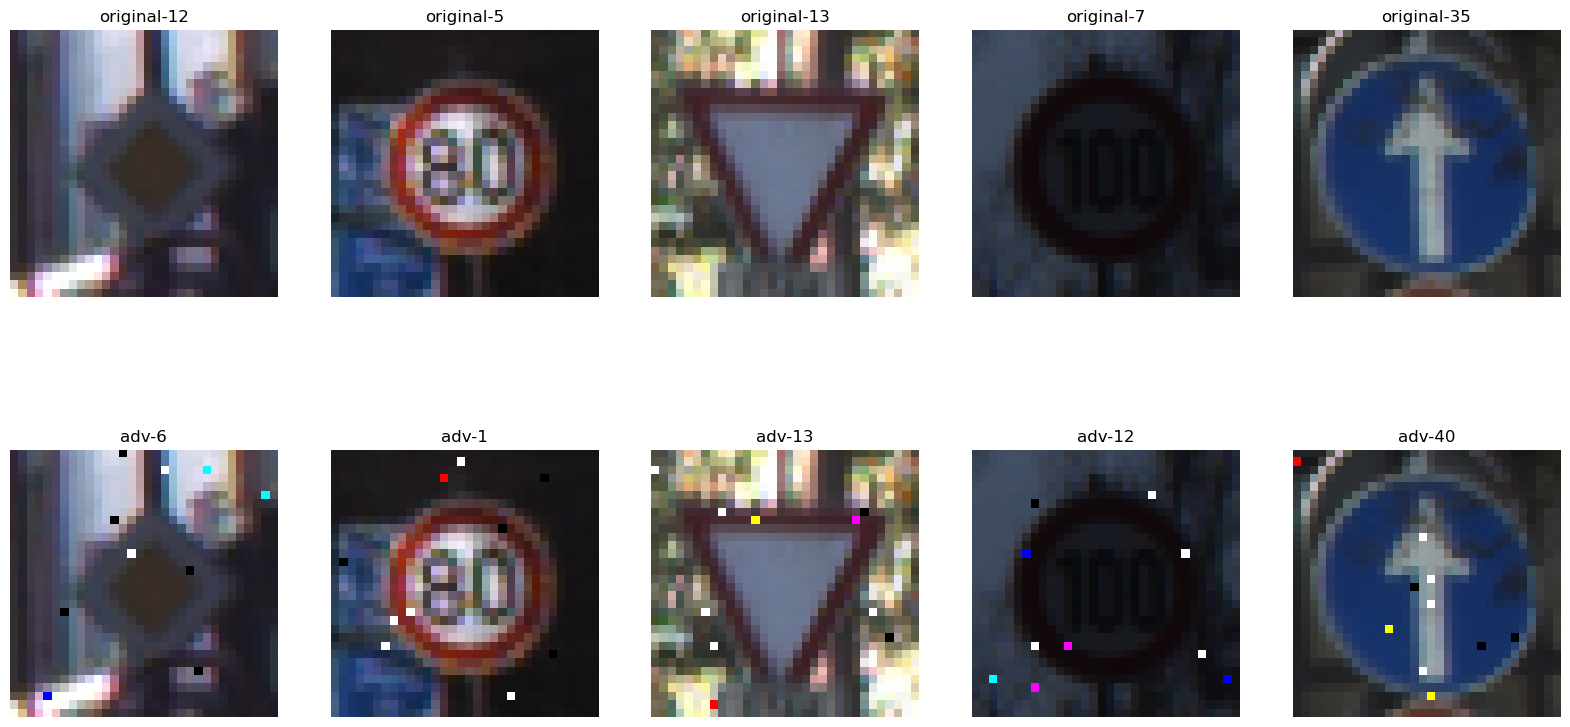

In [17]:
epsilons = [4.5, 8, 5.5, 3.5, 6.5]
attack_model = AttackModel(load_model(join(models_path, 'teacher.h5')), test_images, epsilons)
targets = [test_labels[i] - 1 for i in range(len(test_labels))]
adv_images, adv_labels, adv_disturbances = attack_model.get_adversarial_images(targets, pixel_number=10)
adversarial_images[40:45] = adv_images
adversarial_labels[40:45] = adv_labels
print(test_labels)
print(adv_labels)

plt.figure(figsize=(20, 10))
for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title('original-' + str(test_labels[i]))
    plt.axis("off")
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(adv_images[i]) 
    plt.title('adv-' + str(adv_labels[i]))
    plt.axis("off")

# 4. Red neuronal para generar imágenes adversarias

In [18]:
from keras.layers import  Dense, Reshape, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential

attack_model_nn = Sequential()
attack_model_nn.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
attack_model_nn.add(MaxPooling2D(pool_size=(2, 2)))
attack_model_nn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
attack_model_nn.add(MaxPooling2D(pool_size=(2, 2)))
attack_model_nn.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
attack_model_nn.add(MaxPooling2D(pool_size=(2, 2)))
attack_model_nn.add(Flatten())
attack_model_nn.add(Dense(128, activation='relu'))
attack_model_nn.add(Dense(64, activation='relu'))
attack_model_nn.add(Dense(32, activation='relu'))
attack_model_nn.add(Dense(32*32*3, activation='tanh'))
attack_model_nn.add(Reshape((32, 32, 3)))

attack_model_nn.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
X_images = np.empty((45, 32, 32, 3))
for i in range(9):
    X_images[i*5:(i+1)*5] = test_images
        
attack_model_nn.fit(X_images[:30], adversarial_images[:30], epochs=200, batch_size=10)

Epoch 1/200
3/3 [==============================] - 0s 73ms/step - loss: 0.0156
Epoch 2/200
3/3 [==============================] - 0s 32ms/step - loss: 0.0152
Epoch 3/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0146
Epoch 4/200
3/3 [==============================] - 0s 16ms/step - loss: 0.0142
Epoch 5/200
3/3 [==============================] - 0s 24ms/step - loss: 0.0136
Epoch 6/200
3/3 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 7/200
3/3 [==============================] - 0s 8ms/step - loss: 0.0128
Epoch 8/200
3/3 [==============================] - 0s 13ms/step - loss: 0.0124
Epoch 9/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0120
Epoch 10/200
3/3 [==============================] - 0s 30ms/step - loss: 0.0118
Epoch 11/200
3/3 [==============================] - 0s 11ms/step - loss: 0.0115
Epoch 12/200
3/3 [==============================] - 0s 14ms/step - loss: 0.0114
Epoch 13/200
3/3 [==============================] -

label original:  12
clase modelo:  12
clase modelo-adv:  30


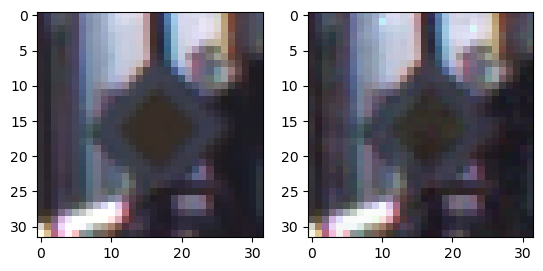

In [28]:
random_number = np.random.randint(0, 12000)
# original_image = X_test[random_number].reshape(1, 32, 32, 3)
# original_label = y_test[random_number]
original_image = test_images[0].reshape(1, 32, 32, 3)
original_label = test_labels[0]

# Cargar modelo de clasificación
signal_model = load_model(join(models_path, 'florez_solarte.h5'))

# Obtener imagen adversarial
adv_image = attack_model_nn(original_image)

# Obtener predicciones
adv_out = signal_model(adv_image)

# Obtener predicciones
original_out = signal_model(original_image)

print('label original: ', original_label)
print('clase modelo: ', np.argmax(original_out))
print('clase modelo-adv: ',np.argmax(adv_out))	

plt.subplot(1, 2, 1)
plt.imshow(original_image.reshape(32, 32, 3))
plt.subplot(1, 2, 2)
plt.imshow(adv_image.numpy().reshape(32, 32, 3))
